# Variability amplitude vs. kinematic age.

Load the catalog of stars in the kinematics-and-rotation project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import kinematics_and_rotation as kr
from kinematics_and_rotation.dispersion import select_stars, MC_dispersion, err_on_sample_std_dev

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [12]:
gaia_mc0 = pd.read_csv("../data/gaia_mc2.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 5500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
bmin = 10
m &= (gaia_mc1.b.values < bmax) * (bmin < gaia_mc1.b.values)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

gaia_mc = gaia_mc1.iloc[m]

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

# Remove velocity outliers
v_clipped, clipping_mask = kr.sigma_clip(gaia_mc.vb.values, 3)
gaia_mc = gaia_mc.iloc[clipping_mask]

gaia_mc.to_csv("../data/gaia_mc_cuts.csv")

(31357, 133)
(11700, 133) no visual binaries or subgiants
(11436, 133) no large vb uncertainties
(11272, 133) no faint stars
(10586, 133) no rapid rotators
(10454, 133) no hot or cold stars
(4635, 133) no high latitude stars


Make bins in period and teff.

In [3]:
x = gaia_mc.color_teffs.values
v = gaia_mc.vb.values
verr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100
xlim = (maxt + 100, mint - 200)

tbins = np.linspace(min(x), max(x), 10)

In [4]:
# y = gaia_mc.Prot.values

# period_bins = 10**np.linspace(np.log10(7), np.log10(50), 9)
# mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
# period_masks = select_stars(gaia_mc, period_bins, "Prot")

# pds, pderrs = [np.zeros((len(period_bins), len(tbins[:-1]))) for i in range(2)]

In [5]:
y = gaia_mc.Rper.values

period_bins = 10**np.linspace(3.2, 4.4, 7)
mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
period_masks = select_stars(gaia_mc, period_bins, "Rper")

pds, pderrs = [np.zeros((len(period_bins), len(tbins[:-1]))) for i in range(2)]

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


[ 1584.89319246  2511.88643151  3981.07170553  6309.5734448
 10000.         15848.93192461 25118.8643151 ]


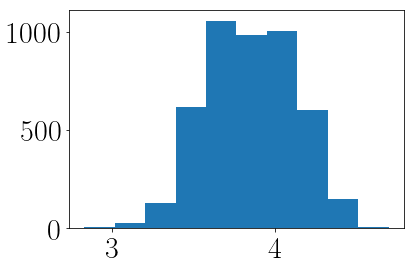

In [6]:
plt.hist(np.log10(gaia_mc.Rper));
print(period_bins)

Calculate dispersions over period and teff bins.

In [7]:
for i, m in enumerate(period_masks):
    d, derr, k, kerr = MC_dispersion(x[m], v[m], xerr[m], verr[m], tbins, 1000, method="std")
    derr = err_on_sample_std_dev(d, len(x[m]))
    pds[i, :] = d
    pderrs[i, :] = err_on_sample_std_dev(d, len(x[m]))

    midbin = np.diff(tbins)*.5+tbins[:-1]

  0%|          | 0/1000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [00:01<00:00, 749.12it/s]


In [8]:
# print(pds)

Calculate colours.

In [9]:
cmap = plt.cm.get_cmap('plasma_r')
pvmin, pvmax = np.min(pds[pds > 0]), np.max(pds[np.isfinite(pds)])
pcolor_values = (pds - pvmin)/(pvmax - pvmin)
prgba_plasma = cmap(pcolor_values)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Make plot.

Text(0.5, 0, '$\\mathrm{T_{eff}~[K]}$')

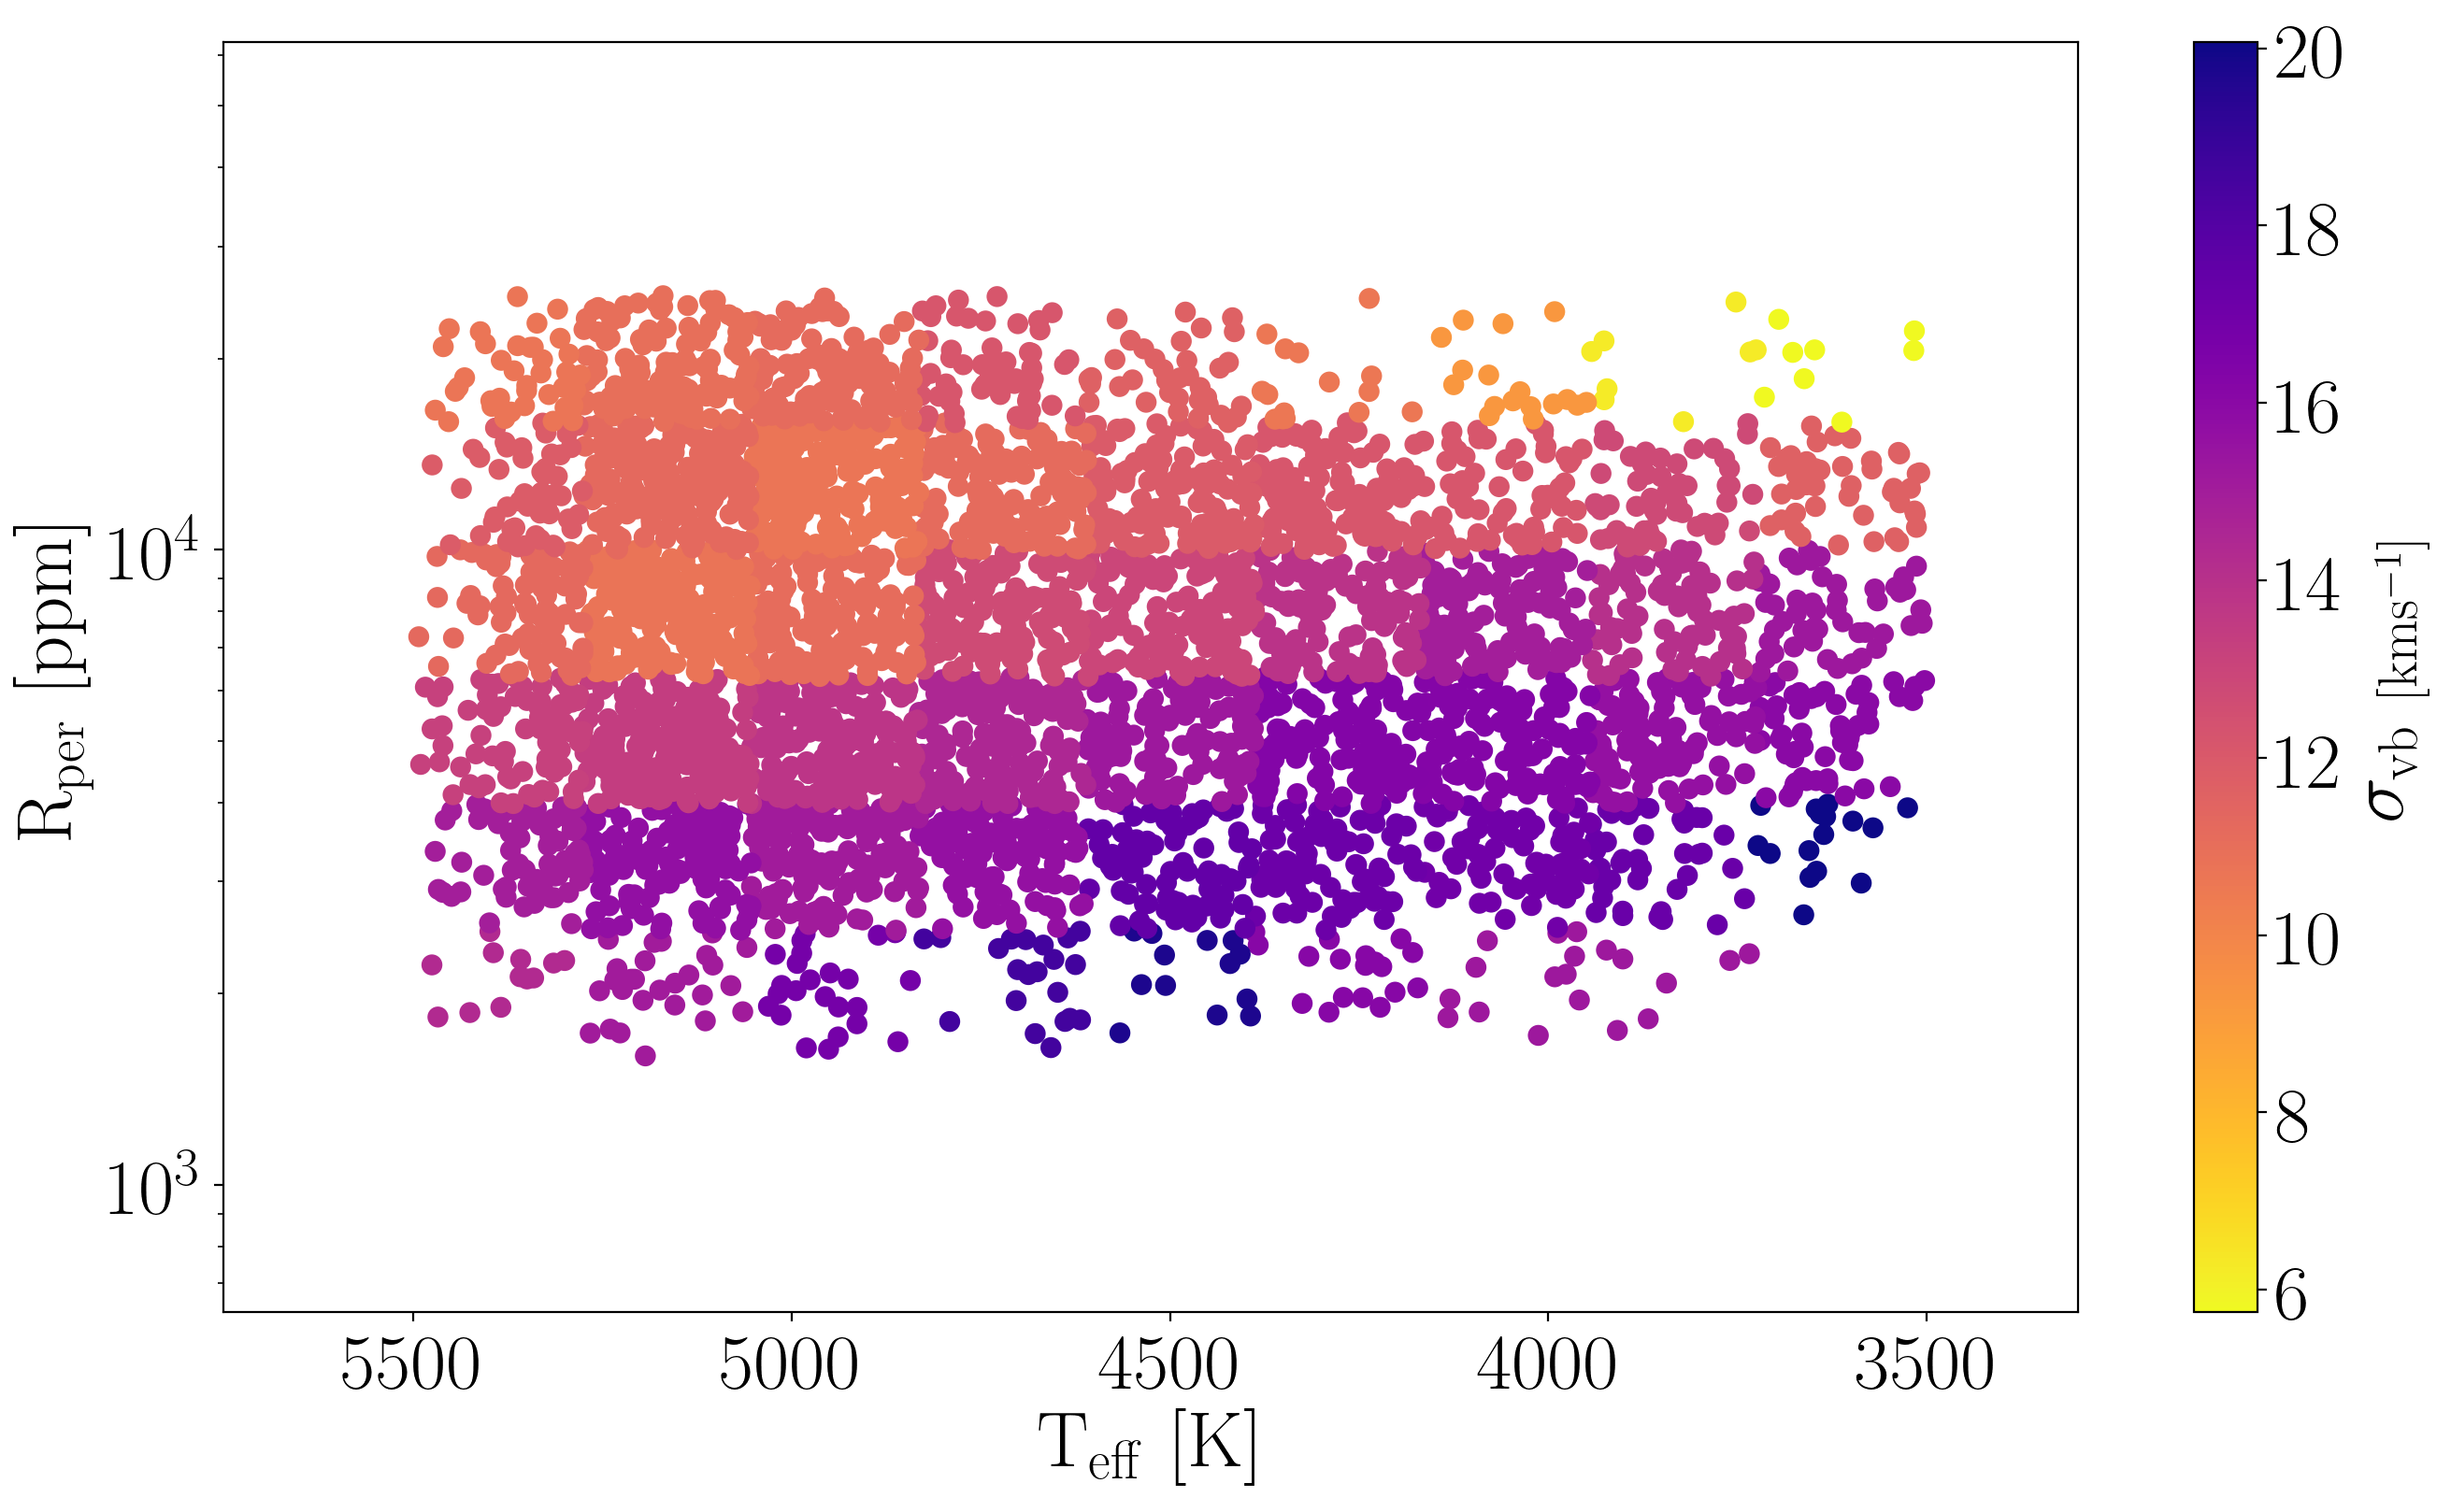

In [22]:
plt.rcParams.update({'legend.fontsize': 18})

fig = plt.figure(figsize=(16, 9), dpi=200)
ax = fig.add_subplot(111)

# plt.plot(gaia_mc1.color_teffs.values, gaia_mc1.Rper.values, ".", color=".7", zorder=0)

for i, m in enumerate(period_masks):
    
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(x[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax, rasterized=True, zorder=1, s=50,
                          cmap="plasma_r")


plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax.set_ylabel("$\mathrm{R_{per}~[ppm]}$")
ax.set_ylim(10**2.8, 10**4.8)
ax.set_xlim(5750, xlim[1])
ax.set_yscale("log")
ax.set_xlabel("$\mathrm{T_{eff}~[K]}$")